In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import os

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   Churn Category                     1121 non-null   object 
 4   Churn Reason                       1121 non-null   object 
 5   Churn Score                        4225 non-null   int64  
 6   City                               4225 non-null   object 
 7   CLTV                               4225 non-null   int64  
 8   Contract                           4225 non-null   object 
 9   Country                            4225 non-null   object 
 10  Customer ID                        4225 non-null   object 
 11  Customer Status                    4225 non-null   objec

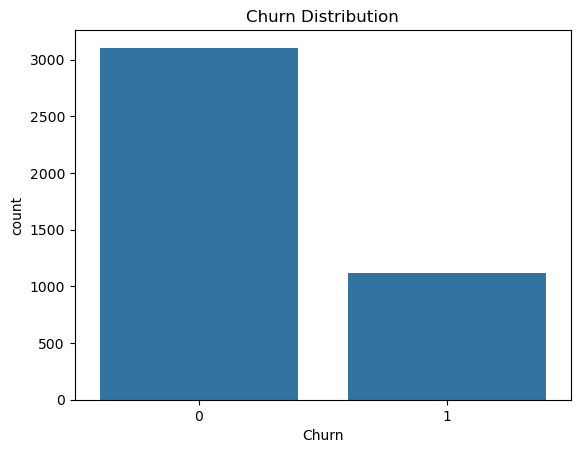

In [9]:
# Load dataset
train_df = pd.read_csv("../data/train/churn_train.csv")
test_df = pd.read_csv("../data/test/churn_test.csv")

# Display first few rows
train_df.head()

# Data Summary
print(train_df.info())
print(train_df.describe())

# Visualize target distribution
sns.countplot(x='Churn', data=train_df)
plt.title("Churn Distribution")
plt.show()

In [10]:
# Define preprocessing functions
def preprocess_data(df, target_column, leaking_features):
    """Preprocess the dataset by encoding, scaling, and removing leaking features."""
    # Encode categorical columns
    encoder = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = encoder.fit_transform(df[col])

    # Split features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Remove leaking features
    X = X.drop(columns=leaking_features)

    return X, y, encoder

def scale_and_balance_data(X, y):
    """Scale numerical features and apply SMOTE for class balancing."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

    return X_balanced, y_balanced, scaler

# Preprocess the training data
leaking_features = ['Churn Score', 'Satisfaction Score', 'Contract', 'Churn Reason', 'Churn Category', 'Customer Status', 'Country', 'Quarter', 'State']
X_train, y_train, encoder = preprocess_data(train_df, target_column='Churn', leaking_features=leaking_features)

# Preprocess the test data
X_test, y_test, _ = preprocess_data(test_df, target_column='Churn', leaking_features=leaking_features)

# Scale and balance the training data
X_train, y_train, scaler = scale_and_balance_data(X_train, y_train)

# Scale the test data
X_test = scaler.transform(X_test)

In [11]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=10, min_samples_leaf=5)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, "../models/churn_model.pkl")
print("Model saved successfully.")

# Save the scaler
joblib.dump(scaler, "../models/scaler.pkl")
print("Scaler saved successfully.")

Model saved successfully.
Scaler saved successfully.


Accuracy: 0.8126
Precision: 0.6291
Recall: 0.7166
F1 Score: 0.6700
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      1035
           1       0.63      0.72      0.67       374

    accuracy                           0.81      1409
   macro avg       0.76      0.78      0.77      1409
weighted avg       0.82      0.81      0.82      1409



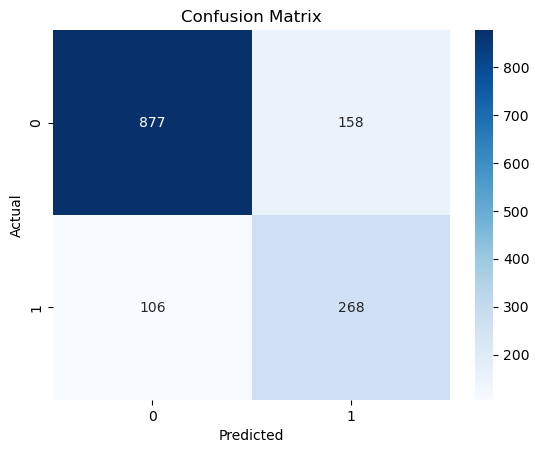

In [12]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Cross-Validation Accuracy:", scores.mean())

Cross-Validation Scores: [0.80676329 0.81723027 0.88808374 0.89041096 0.89846898]
Mean Cross-Validation Accuracy: 0.8601914460443698


In [20]:
# Preprocess the training data
leaking_features = ['Churn Score', 'Satisfaction Score', 'Contract', 'Churn Reason', 'Churn Category', 'Customer Status', 'Country', 'Quarter', 'State']
X_train, y_train, encoder = preprocess_data(train_df, target_column='Churn', leaking_features=leaking_features)

# Save feature names before scaling
feature_names = X_train.columns.tolist()

# Scale and balance the training data
X_train, y_train, scaler = scale_and_balance_data(X_train, y_train)

# Scale the test data
X_test = scaler.transform(X_test)

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


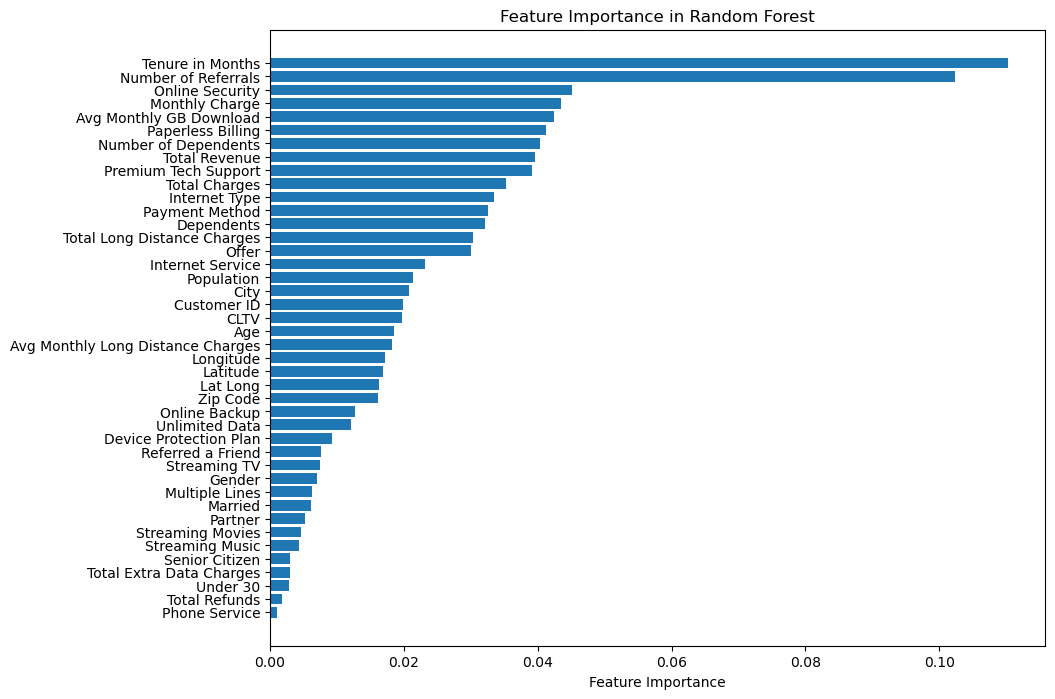

In [21]:
# Plot feature importance
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

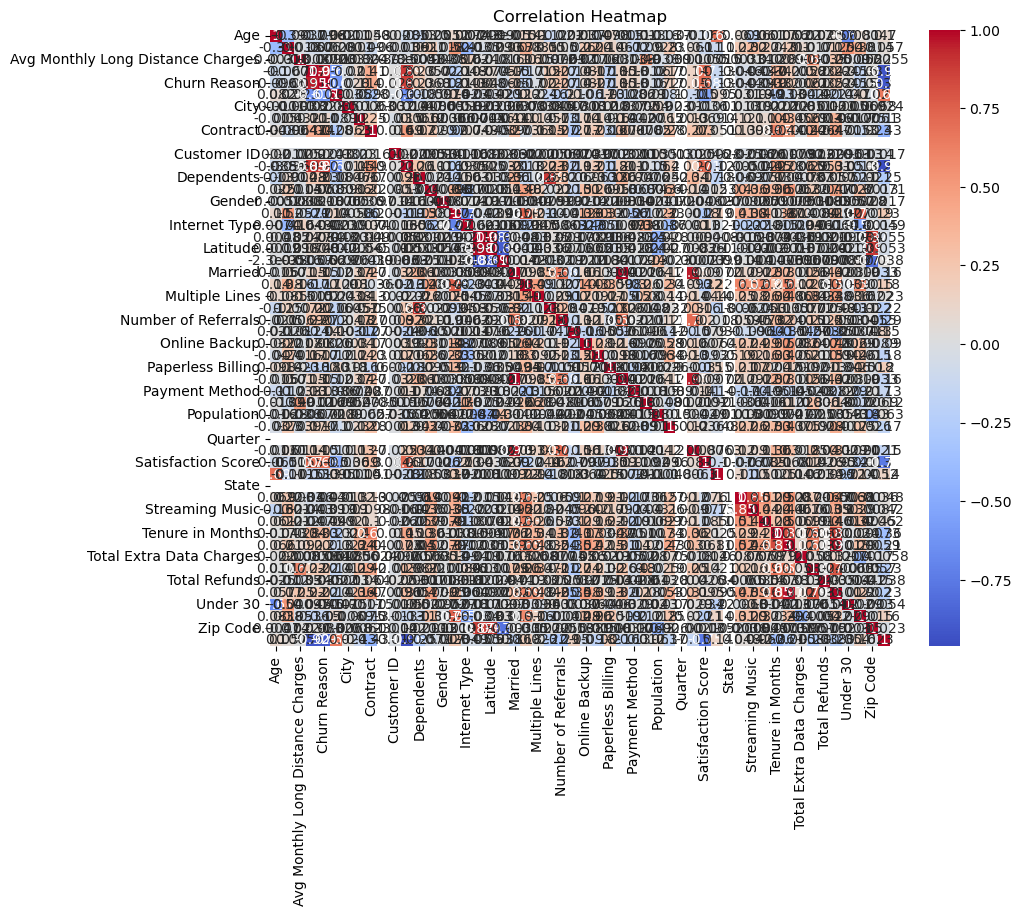

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [23]:
# Save the feature columns
joblib.dump(feature_names, "../models/feature_columns.pkl")
print("Feature columns saved successfully.")

Feature columns saved successfully.
